In [1]:
import tensorflow as tf
import simplejson
import matplotlib.pyplot as plt
%matplotlib inline
import threading
import tensorflow.contrib.slim as slim
from utils import data_utils, train_utils
import datetime
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import train
import pandas as pd
from shapely import wkt
import time
import sys
from inference import pred_for_each_quarter, test_input, stitch_mask

In [2]:
hypes = './hypes/hypes.json'
with open(hypes, 'r') as f:
    H = simplejson.load(f)
    H['batch_size'] = 1
    H['pad'] = 100
    H['x_width'] = 1920
    H['x_height'] = 1920
    H['print_iter'] = 100
    H['save_iter'] = 500
    H['crop_size'] = [1700, 1700]

    print_iter = H['print_iter']
    num_channel = H['num_channel']
    x_width = H['x_width']
    x_height = H['x_height']
    batch_size = H['batch_size']
    class_type = H['class_type']
    pad = H['pad']
    class_type = H['class_type']
    log_dir = H['log_dir']
    save_iter = H['save_iter']

In [3]:
img_in = tf.placeholder(dtype=tf.float32, shape=[batch_size, x_width, x_height, 3])
logits, pred = train.build_pred(img_in, H, 'test')

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
saver = tf.train.Saver()
sess = tf.Session(config = config)
saver.restore(sess, save_path='/Users/bhalindergill/Projects/dstl_unet/log_dir/11-19_19-3_cross_entropy/ckpt/ckpt-6001')

In [5]:
ids_with_instance = train_utils.generate_train_ids(class_type)
print 'IDs of training data with instance of class {} ({}): {}'.format(
    class_type, data_utils.CLASSES[class_type + 1], ids_with_instance)

IDs of training data with instance of class 6 (Fast H2O): [8]


In [7]:
jaccard_indices = {}

# Compare training data with predictions

Level 1
feat_trans.shape
(1700, 1700, 3)
feat_trans.shape
(1700, 1638, 3)
feat_trans.shape
(1650, 1700, 3)
feat_trans.shape
(1650, 1638, 3)
Level 2
[9930806   20760   13770   11535   11653   11585   11162   11627   16142
 1143260]
[  3.00828871e-12   1.00000000e-01   2.00000000e-01   3.00000000e-01
   4.00000000e-01   5.00000000e-01   6.00000000e-01   7.00000000e-01
   8.00000000e-01   9.00000000e-01   1.00000000e+00]
Level 3
Level 4
Level 5
Level 6
Processing ImageId: 8 (No. 6070_2_3); Class (6): Fast H2O
Jaccard indices {'6070_2_3': 0.9576860161123454}
Mean Jaccard index 0.957686016112


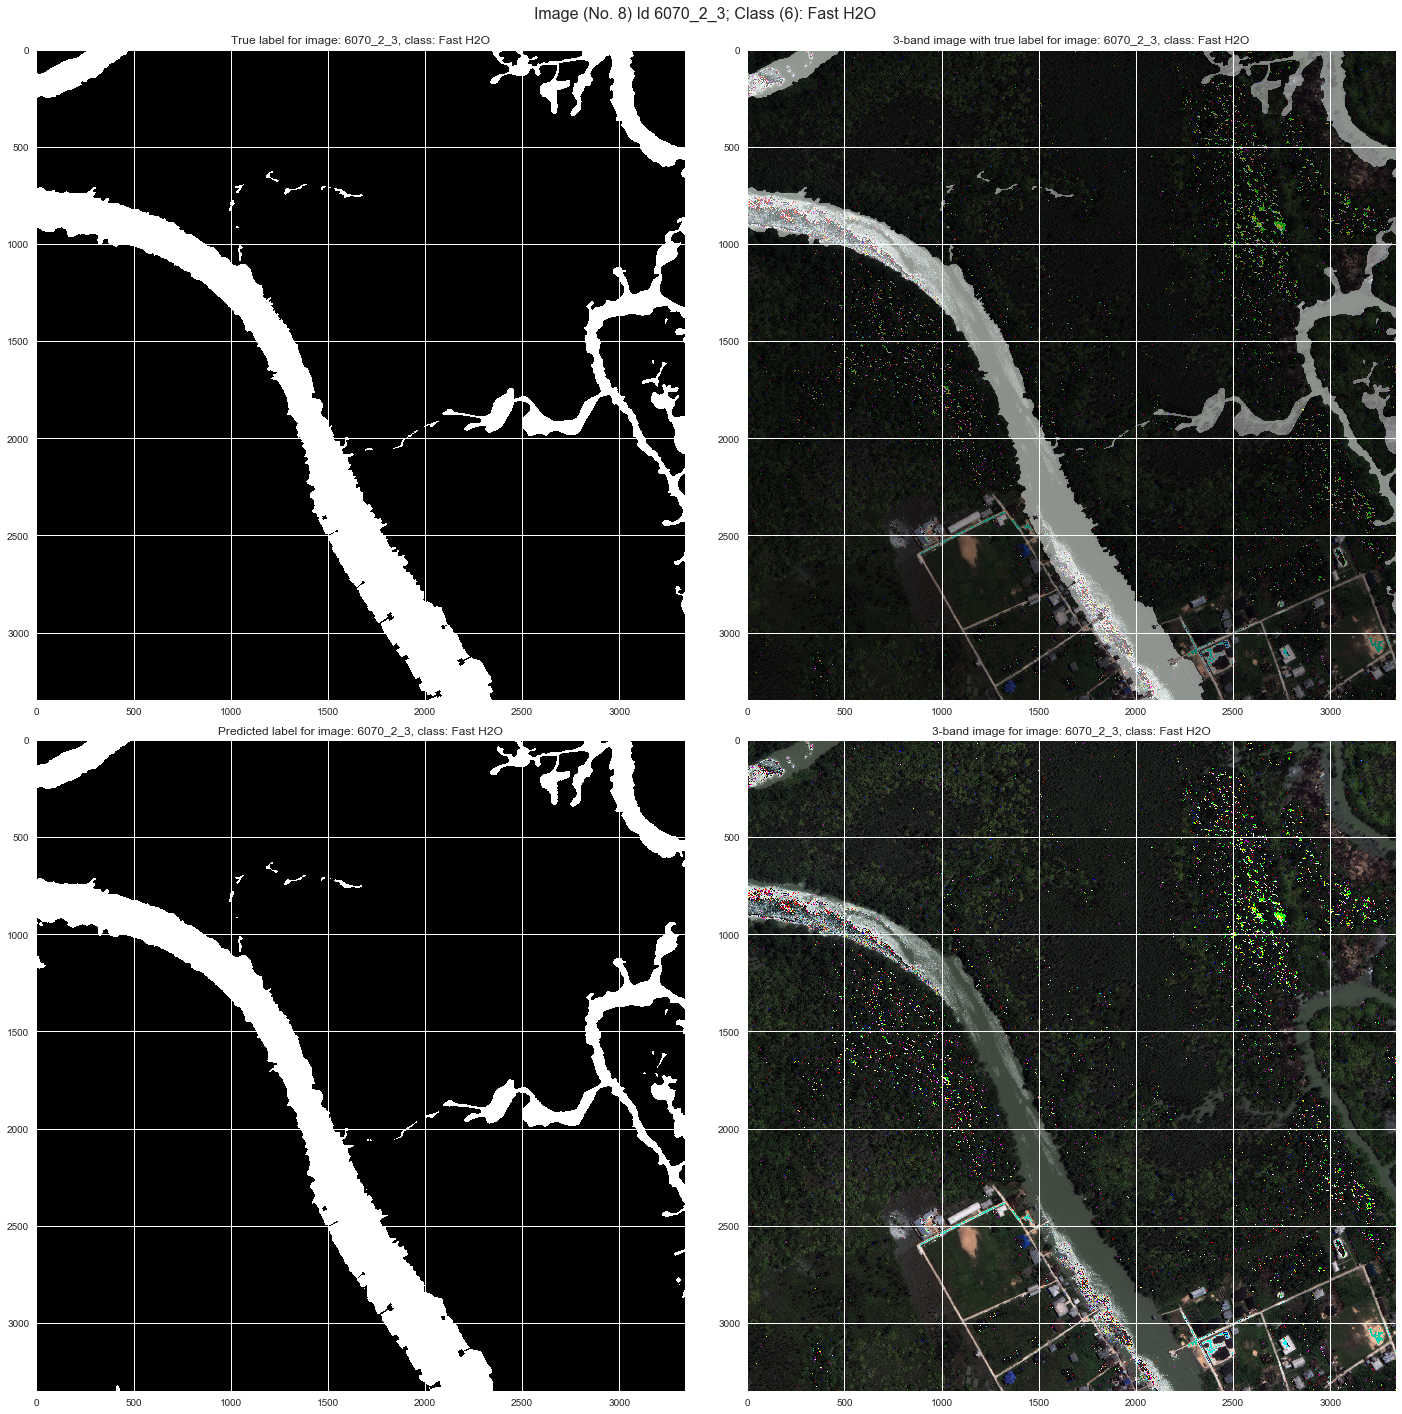

In [8]:
for img_id in ids_with_instance:
    
    img_data = data_utils.ImageData(img_id)
    img_data.load_image()
    img_data.create_train_feature()
    img_data.create_label()
    print 'Level 1'
    mask_stack, shape_stack = pred_for_each_quarter(sess, img_in, pred, img_data, H)
    print 'Level 2'
    #mask = np.squeeze((mask_stack > 0.5).astype(np.int))
    mask = stitch_mask(mask_stack, img_data.image_size, shape_stack, H)
    print 'Level 3'
    polygons = data_utils.mask_to_polygons(mask=mask, img_id=img_id, test=False, epsilon=1)
    print 'Level 4'
    true_polygons = data_utils.get_polygon_list(
        image_id=data_utils.train_IDs_dict[img_id], class_type=class_type + 1)
    print 'Level 5'
    jaccard_indices[data_utils.train_IDs_dict[img_id]] = \
    polygons.intersection(true_polygons).area / polygons.union(true_polygons).area
    print 'Level 6'
    
    alpha = 0.4
    fig, axs = plt.subplots(2, 2, figsize = [20, 20])
    print 'Processing ImageId: {} (No. {}); Class ({}): {}'.format(
        img_id, data_utils.train_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1])
    
    fig.suptitle('Image (No. {}) Id {}; Class ({}): {}'.format(
        img_id, data_utils.train_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1]), 
                 fontsize = 16)
    
    mask_train = img_data.label[:, :, class_type]
#     print np.amax(mask_train)
#     print mask_train.shape
#     print np.sum(mask_train)
#     hist, bin_edges = np.histogram(mask_train.flatten())
#     print hist
#     print bin_edges
    
    axs[0, 0].imshow(img_data.label[:, :, class_type], cmap = plt.cm.gray)
    axs[0, 0].set_title('True label for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[0, 1].imshow(data_utils.scale_percentile(img_data.three_band_image))
    axs[0, 1].imshow(img_data.label[:, :, class_type], cmap = plt.cm.gray, alpha = alpha)
    axs[0, 1].set_title('3-band image with true label for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[1, 0].imshow(mask, cmap = plt.cm.gray)
#     dummy = np.ones([img_data.image_size[0], img_data.image_size[1]])
#     dummy[500,500] = 0
#     axs[1, 0].imshow(dummy, cmap = plt.cm.gray)
    axs[1, 0].set_title('Predicted label for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[1, 1].imshow(data_utils.scale_percentile(img_data.three_band_image))
    #axs[1, 1].imshow(mask, cmap = plt.cm.gray, alpha = alpha)
    axs[1, 1].set_title('3-band image for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

print 'Jaccard indices {}'.format(jaccard_indices)
print 'Mean Jaccard index {}'.format(np.mean(jaccard_indices.values()))

In [ ]:
#ids_w_o_instance = sorted(list(set(range(25)) - set(ids_with_instance)))
ids_w_o_instance = [17, 18, 19, 20]
print 'IDs of training data w/o instance of class {} ({}): {}'.format(
    class_type, data_utils.CLASSES[class_type + 1], ids_w_o_instance)

In [ ]:
for img_id in ids_w_o_instance:
    
    print 'Processing ImageId (No. {}): {}; Class ({}): {}'.format(
        img_id, data_utils.train_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1])
    
    img_data = data_utils.ImageData(img_id)
    img_data.load_image()
    img_data.create_train_feature()
    img_data.create_label()
    mask_stack, shape_stack = pred_for_each_quarter(sess, img_in, pred, img_data, H)
    mask = stitch_mask(mask_stack, img_data.image_size, shape_stack, H)
    polygons = data_utils.mask_to_polygons(mask=mask, img_id=img_id, test=False, epsilon=1)
    true_polygons = data_utils.get_polygon_list(
        image_id=data_utils.train_IDs_dict[img_id], class_type=class_type + 1)
    
    jaccard_indices[data_utils.train_IDs_dict[img_id]] = \
    polygons.intersection(true_polygons).area / polygons.union(true_polygons).area \
    if polygons.union(true_polygons).area else 1.
    
    alpha = 0.4
    fig, axs = plt.subplots(2, 2, figsize = [20, 20])
    print 'Processing ImageId: {} (No. {}); Class ({}): {}'.format(
        img_id, data_utils.train_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1])
    
    fig.suptitle('Image (No. {}) Id {}; Class ({}): {}'.format(
        img_id, data_utils.train_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1]), 
                 fontsize = 16)
    
    axs[0, 0].imshow(img_data.label[:, :, class_type], cmap = plt.cm.gray)
    axs[0, 0].set_title('True label for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[0, 1].imshow(data_utils.scale_percentile(img_data.three_band_image))
    axs[0, 1].imshow(img_data.label[:, :, class_type], cmap = plt.cm.gray, alpha = alpha)
    axs[0, 1].set_title('3-band image with true label for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[1, 0].imshow(mask, cmap = plt.cm.gray)
    axs[1, 0].set_title('Predicted label for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[1, 1].imshow(data_utils.scale_percentile(img_data.three_band_image))
    #axs[1, 1].imshow(mask, cmap = plt.cm.gray, alpha = alpha)
    axs[1, 1].set_title('3-band image for image: {}, class: {}'.format(
        data_utils.train_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    
print 'Jaccard indices {}'.format(jaccard_indices)
print 'Mean Jaccard index {}'.format(np.mean(jaccard_indices.values()))

# Predictions on the test data

In [ ]:
for img_id in range(30, 35):
#for img_id in [30]:
    
    img_data = data_utils.ImageData(img_id, phase='test')
    img_data.load_image()
    img_data.create_train_feature()
    
    mask_stack, shape_stack = pred_for_each_quarter(sess, img_in, pred, img_data, H)
    mask = stitch_mask(mask_stack, img_data.image_size, shape_stack, H)
    
    alpha = 0.4
    fig, axs = plt.subplots(1, 2, figsize = [20, 10])
    print 'Processing ImageId: {} (No. {}); Class ({}): {}'.format(
        img_id, data_utils.test_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1])
    
    fig.suptitle('Image (No. {}) Id {}; Class ({}): {}'.format(
        img_id, data_utils.test_IDs_dict[img_id], class_type, data_utils.CLASSES[class_type + 1]), 
                 fontsize = 16)
    
#     for i in range(2):
#         for j in range(2):

    axs[0].imshow(mask, cmap = plt.cm.gray)
    axs[0].set_title('Predicted label for image: {}, class: {}'.format(
        data_utils.test_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    axs[1].imshow(data_utils.scale_percentile(img_data.three_band_image))
    axs[1].imshow(mask, cmap = plt.cm.gray, alpha = alpha)
    axs[1].set_title('3-band image with predicted label for image: {}, class: {}'.format(
        data_utils.test_IDs_dict[img_id], data_utils.CLASSES[class_type + 1]))
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
